In [1]:
import glob
import os
import shutil
from PIL import Image 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
RSEED=123

2022-12-04 21:47:46.211261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 21:47:46.384443: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I1204 21:47:46.484661814 3189613 ev_epoll1_linux.cc:121]     grpc epoll fd: 70
D1204 21:47:46.484695310 3189613 ev_posix.cc:141]            Using polling engine: epoll1
D1204 21:47:46.484725582 3189613 lb_policy_registry.cc:43]   registering LB policy factory for "grpclb"
D1204 21:47:46.484734394 3189613 lb_policy_registry.cc:43]   registering LB policy factory for "rls_experimental"
D1204 21:47:46.484742820 3189613 lb_policy_registry.cc:43]   registering LB policy factory for "priority_experimental"
D1204 21:47:46

In [3]:
tf.config.list_logical_devices('TPU')

2022-12-04 21:47:48.692143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 21:47:51.991879: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fdc3e0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-12-04 21:47:51.991913: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-12-04 21:47:51.991920: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-12-04 21:47:51.991926: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-12-04 21:47:51.991932: I tensorflow/compiler/xla/service/service.cc:181]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
batch_size = 128
buffer_size = 1000
img_height = 240
img_width = 240
scan_channels = 4
output_classes = 5


In [6]:
colour_list = ['w', '#d73027', '#91bfdb', '0.8', '#fee090']
cmap = ListedColormap(colour_list)

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]),cmap=cmap)
        plt.axis('off')
    plt.show()
  
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [7]:
train_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','train','image_data')
train_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','train','map_data')


In [8]:
image_filenames = os.listdir(train_image_dir)
map_filenames = [filename.replace('allseq', 'map') for filename in image_filenames]
image_filepaths = [os.path.join(train_image_dir,filename) for filename in image_filenames]
map_filepaths = [os.path.join(train_map_dir,filename) for filename in map_filenames]

In [9]:
train_image_filepaths, val_image_filepaths, train_map_filepaths, val_map_filepaths = train_test_split(
    image_filepaths, 
    map_filepaths, 
    test_size=0.2,
    random_state=RSEED,
    )
    

In [10]:
train_image_data = tf.data.Dataset.list_files(train_image_filepaths, shuffle=False)
train_map_data = tf.data.Dataset.list_files(train_map_filepaths, shuffle=False)
train_data = tf.data.Dataset.zip((train_image_data, train_map_data))
val_image_data = tf.data.Dataset.list_files(val_image_filepaths, shuffle=False)
val_map_data = tf.data.Dataset.list_files(val_map_filepaths, shuffle=False)
val_data = tf.data.Dataset.zip((val_image_data, val_map_data))

In [11]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def alter_segmap(x):
    return tf.where(x==4,tf.constant(3,dtype='uint8'),x)

def read_image_map(image, seg_map):
   image = tf.io.read_file(image)
   image = tf.io.decode_png(image, channels=4)
   seg_map = tf.io.read_file(seg_map)
   seg_map = tf.io.decode_png(seg_map, channels=1)
   # Change scaler below to scaler_0_1 to get initial values between 0 and 1
   return scaler_neg1_1(tf.cast(image, 'float32')) ,seg_map


In [12]:
train_batch = (
    train_data.cache()
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .repeat()
    .map(read_image_map)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_batch = (
    val_data
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .map(read_image_map)
    .batch(batch_size),
)

In [13]:
# Define convolution layer steps
initializer = tf.random_normal_initializer(0., 0.02)

def horizontal_convolution(input, num_filters, dropout_rate=0.0):
    
    x = tf.keras.layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        padding= 'same',
        strides=1,
        kernel_initializer=initializer,
        use_bias=False,
    )(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x) 
    return x


def down_step(input, num_filters, dropout_rate=0.0):
    x = horizontal_convolution(
        input=input,
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    horizontal_out = horizontal_convolution(
        x, 
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    down_out = tf.keras.layers.MaxPooling2D(
        pool_size=2,
        strides=2, 
        padding = 'same'
    )(horizontal_out)
    return down_out, horizontal_out


def up_step(
    up_input, 
    horizontal_input, 
    num_filters, 
    dropout_rate=0.0, 
):
    x = tf.keras.layers.Conv2DTranspose(
        filters=num_filters,
        kernel_size=3, 
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False,
    )(up_input)
    x = tf.keras.layers.Concatenate()([x, horizontal_input])
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate
    )
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate
    )
    return x

In [14]:
# Define U-Net topology
def unet(
    input_shape, 
    output_channels, 
    scale_filters=1.0, 
    dropout_rate=0.0,
    final_dropout=True
    ):

    final_dropout_rate=0.0
    if final_dropout:
        final_dropout_rate = dropout_rate

    inputs = tf.keras.layers.Input(shape=input_shape)

    down_1, cross_1 = down_step(
        inputs, 
        int(64*scale_filters), 
        dropout_rate=dropout_rate
    )  # 240 -> 120
    down_2, cross_2 = down_step(
        down_1, 
        int(128*scale_filters), 
        dropout_rate=dropout_rate
    )  # 120 -> 60
    down_3, cross_3 = down_step(
        down_2, 
        int(256*scale_filters), 
        dropout_rate=dropout_rate
    )  # 60 -> 30
    down_4, cross_4 = down_step(
        down_3, 
        int(512*scale_filters), 
        dropout_rate=dropout_rate
    )  # 30 -> 15

    bottom = horizontal_convolution(
        down_4, 
        int(1024*scale_filters), 
        dropout_rate=dropout_rate
    )

    up_4 = up_step(
        bottom, 
        cross_4, 
        int(512*scale_filters), 
        dropout_rate=dropout_rate
    )  # 15 -> 30
    up_3 = up_step(
        up_4, 
        cross_3, 
        int(256*scale_filters), 
        dropout_rate=dropout_rate
    )  # 30 -> 60
    up_2 = up_step(
        up_3, 
        cross_2, 
        int(128*scale_filters), 
        dropout_rate=dropout_rate
    )  # 60 -> 120
    up_1 = up_step(
        up_2, 
        cross_1, 
        int(64*scale_filters), 
        dropout_rate=final_dropout_rate
    )  # 120 -> 240
    
    outputs = horizontal_convolution(up_1, output_channels)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [15]:
with strategy.scope():
    input_shape = (img_width,img_height,scan_channels)
    model = unet(
        input_shape=input_shape, 
        output_channels=output_classes, 
        dropout_rate=0.2
    )
    model.load_weights(
        'model_checkpoints/unet_bs128_pat10_dr0.2_lr0.0001_scratch-2022-12-03-22:56:03-085-0.0323.ckpt'
        )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

2022-12-04 21:48:02.425888: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-04 21:48:02.485599: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-12-04 21:48:13.037649: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open model_checkpoints/unet_bs128_pat10_dr0.2_lr0.0001_scratch-2022-12-03-22:56:03-085-0.0323.ckpt: FAILED_PRECONDITION: model_checkpoints/unet_bs128_pat10_dr0.2_lr0.0001_scratch-2022-12-03-22:56:03-085-0.0323.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [16]:
# create test data
test_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy','test','image_data')
test_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy','test','map_data')


In [17]:

test_image_filenames = os.listdir(test_image_dir)
test_image_filepaths = [os.path.join(test_image_dir,x) for x in test_image_filenames]
test_map_filepaths = [
    os.path.join(test_map_dir,x.replace('allseq','map')) for x in test_image_filenames
]


In [18]:
test_image_data = tf.data.Dataset.list_files(test_image_filepaths, shuffle=False)
test_map_data = tf.data.Dataset.list_files(test_map_filepaths, shuffle=False)
test_data = tf.data.Dataset.zip((test_image_data, test_map_data))
test_batch = (
    test_data
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .map(read_image_map)
    .batch(32),
)

In [19]:
images, masks = next(iter(test_batch[0].take(1)))

    

2022-12-04 21:48:17.398845: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:14327324618773702918
2022-12-04 21:48:17.459170: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-04 21:48:17.565802: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-04 21:48:17.722261: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(12846360229965167098), session_name()


1/1 [==============================] - 10s 10s/step


2022-12-04 21:48:26.015781: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 12846360229965167098 with session name  took 8.293442497s and succeeded
2022-12-04 21:48:26.023209: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(12846360229965167098), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_14327324618773702918", property.function_library_fingerprint = 17167677666572916526, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "2,240,240,4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-04 21:48:26.023253: I tensorflow/

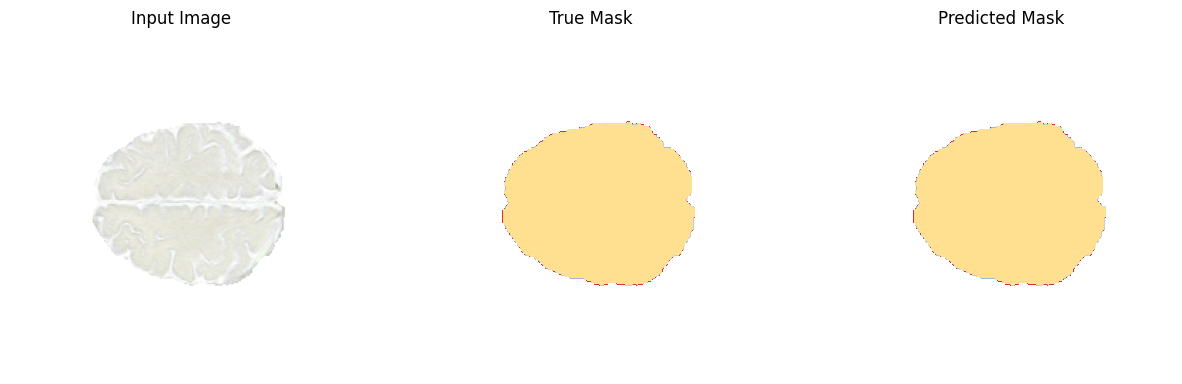

In [20]:
num=30
sample_image, sample_mask = images[num], masks[num]
show_predictions()

In [21]:
test_loss, test_accuracy =  model.evaluate(val_batch[0])

2022-12-04 21:48:27.404774: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 15443
  }
}
attr {
  key: "is_files"
  value {
    b: true
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:3"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-12-04 

120/121 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.9956

2022-12-04 21:49:52.495214: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(12212817228538235230), session_name()


121/121 [==============================] - 131s 612ms/step - loss: 0.0322 - accuracy: 0.9956


2022-12-04 21:50:38.317850: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 12212817228538235230 with session name  took 45.822526954s and succeeded
2022-12-04 21:50:38.329821: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(12212817228538235230), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_11319455582183161048", property.function_library_fingerprint = 4487658004175824632, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "11,240,240,4,;11,240,240,1,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-04 21:50:38.329891: I

In [22]:
test_loss, test_accuracy 

(0.032232798635959625, 0.9955682158470154)

In [23]:
test_patients = list(set([filename[:15] for filename in test_image_filenames]))


for patient in test_patients:
    for pred_slice in range(155):
        scan_image_name = f'{patient}_11_allseq_{pred_slice:03}.png'
        scan_image = tf.io.read_file(os.path.join(test_image_dir,scan_image_name))
        scan_image = tf.io.decode_png(scan_image, channels=4)
        scan_map = np.array(Image.open(
            os.path.join(test_map_dir,scan_image_name.replace('allseq','map'))
        ))
        tensor_image = tf.expand_dims(
            scaler_neg1_1(tf.cast(scan_image, 'float32')),
            0
        )
        
        pred_map = np.squeeze(np.argmax(model.predict(tensor_image), axis=-1))
        pred_map[-1,-4:] = 1,2,3,4
        scan_map[-1,-4:] = 1,2,3,4
        plots=[scan_image[:,:,0],scan_map,pred_map]
        cmaps=['gist_gray',cmap,cmap]
        fig, axes = plt.subplots(1,3,figsize=(10, 10))
        plt.subplots_adjust(wspace=0, hspace=0)
        for i in range(3):
            axes[i].imshow(plots[i], cmap=cmaps[i])
            axes[i].axis('off')
        plt_name = os.path.join('predictions',scan_image_name.replace('allseq','predmap'))
        fig.savefig(plt_name, format='png', bbox_inches='tight')
        plt.close()


1/1 [==============================] - 0s 426ms/step


In [39]:
from apng import APNG

for patient in test_patients:
    
    png_list = [
        os.path.join(
            'predictions',f'{patient}_11_predmap_{x:03}.png'
        ) for x in range(155)
    ]

    APNG.from_files(
        png_list+png_list[::-1], delay=50
    ).save(os.path.join('prediction_movies',f'{patient}_11_predmap_all.png'))